In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import datetime
import math
from tqdm.notebook import tqdm
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

In [4]:
#load datasets
am_df = pd.read_csv("data/american_stock.csv")
eu_df = pd.read_csv("data/european_index.csv")
rf_df = pd.read_csv("data/FEDFUNDS.csv")
# stock_price_df = pd.read_csv("data/stock_prices.csv")
stock_price_df = pd.read_csv("data/ndx_historical.csv")

In [5]:
rf_df["DATE"] = pd.to_datetime(rf_df["DATE"], format="%Y-%m-%d")
rf_df.head()

,DATE,FEDFUNDS
0,2013-02-01,0.15
1,2013-03-01,0.14
2,2013-04-01,0.15
3,2013-05-01,0.11
4,2013-06-01,0.09


In [6]:
# How many intervals to look back for when calculating volatility
volatility_intervals = 100

stock_price_df["Date"] = pd.to_datetime(stock_price_df["Date"])
stock_price_df["volatility"] = stock_price_df["Close/Last"].rolling(volatility_intervals).std() / stock_price_df["Close/Last"]
stock_price_df = stock_price_df.dropna()
stock_price_df

,Date,Close/Last,Volume,Open,High,Low,volatility
99,2022-10-31,11405.57,--,11465.21,11482.99,11331.26,0.049919
100,2022-10-28,11546.21,--,11176.99,11563.16,11176.99,0.048574
101,2022-10-27,11191.63,--,11387.71,11417.04,11179.90,0.049597
102,2022-10-26,11405.90,--,11409.79,11657.06,11388.34,0.048206
103,2022-10-25,11669.99,--,11482.87,11681.85,11480.41,0.046303
...,...,...,...,...,...,...,...
2537,2013-04-01,2797.07,--,2818.69,2821.48,2789.76,0.036904
2538,2013-03-29,2818.69,--,0.00,0.00,0.00,0.036770
2539,2013-03-28,2818.69,--,2809.98,2820.67,2804.53,0.036887
2540,2013-03-27,2809.98,--,2806.50,2811.79,2783.86,0.036869


In [7]:
am_df = am_df[["date", "symbol", "exdate", "cp_flag", "strike_price", "best_bid", "best_offer", "exercise_style"]]
am_df["date"] = pd.to_datetime(am_df["date"], format="%Y%m%d")
am_df["exdate"] = pd.to_datetime(am_df["exdate"], format="%Y%m%d")
am_df["tte"] = am_df["exdate"] - am_df["date"]
am_df["rf_join_date"] = pd.to_datetime(am_df["date"].apply(lambda x: datetime.date(x.year, x.month, 1)))
am_df = pd.merge(am_df, rf_df, left_on="rf_join_date", right_on="DATE")
am_df = pd.merge(am_df, stock_price_df, left_on="date", right_on="Date")
am_df = am_df[["date", "symbol", "exdate", "cp_flag", "strike_price", "best_bid", "best_offer", "exercise_style", "tte", "Close/Last", "FEDFUNDS", "volatility"]]
am_df.head()

,date,symbol,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style,tte,Close/Last,FEDFUNDS,volatility
0,2015-01-02,AAPL 150102C100000,2015-01-02,C,100000,9.20,9.35,A,0 days,4230.24,0.11,0.027469
1,2015-01-02,AAPL 150102C101000,2015-01-02,C,101000,8.20,8.40,A,0 days,4230.24,0.11,0.027469
2,2015-01-02,AAPL 150102C102000,2015-01-02,C,102000,7.25,7.35,A,0 days,4230.24,0.11,0.027469
3,2015-01-02,AAPL 150102C103000,2015-01-02,C,103000,6.20,6.40,A,0 days,4230.24,0.11,0.027469
4,2015-01-02,AAPL 150102C104000,2015-01-02,C,104000,5.25,5.35,A,0 days,4230.24,0.11,0.027469


In [8]:
eu_df = eu_df[["date", "symbol", "exdate", "cp_flag", "strike_price", "best_bid", "best_offer", "exercise_style"]]
eu_df["date"] = pd.to_datetime(eu_df["date"], format="%Y%m%d")
eu_df["exdate"] = pd.to_datetime(eu_df["exdate"], format="%Y%m%d")
eu_df["tte"] = eu_df["exdate"] - eu_df["date"]
eu_df["rf_join_date"] = pd.to_datetime(eu_df["date"].apply(lambda x: datetime.date(x.year, x.month, 1)))
eu_df = pd.merge(eu_df, rf_df, left_on="rf_join_date", right_on="DATE")
eu_df = pd.merge(eu_df, stock_price_df, left_on="date", right_on="Date")
eu_df = eu_df[["date", "symbol", "exdate", "cp_flag", "strike_price", "best_bid", "best_offer", "exercise_style", "tte", "Close/Last", "FEDFUNDS", "volatility"]]
eu_df.head()

,date,symbol,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style,tte,Close/Last,FEDFUNDS,volatility
0,2015-01-02,NDX 150109C3100000,2015-01-09,C,3100000,1124.9,1134.0,E,7 days,4230.24,0.11,0.027469
1,2015-01-02,NDX 150109C3125000,2015-01-09,C,3125000,1099.9,1109.0,E,7 days,4230.24,0.11,0.027469
2,2015-01-02,NDX 150109C3150000,2015-01-09,C,3150000,1074.9,1084.0,E,7 days,4230.24,0.11,0.027469
3,2015-01-02,NDX 150109C3175000,2015-01-09,C,3175000,1049.9,1059.0,E,7 days,4230.24,0.11,0.027469
4,2015-01-02,NDX 150109C3200000,2015-01-09,C,3200000,1024.9,1034.0,E,7 days,4230.24,0.11,0.027469


In [9]:
# European Options Pricing Monte Carlo Simulation assuming log-normal distribution of stock, e.g. SPX.
# Larger the num_simulations, the more accurate the model becomes, at square root scale
# Default number is 1,000,000 simulations
def monte_carlo_european_option_pricing(init_price, strike, ttm, int_rate, volatility, type_of_option='call', num_simulations=1000000, plot=False, num_paths_to_plot=25):
    """
    Monte Carlo pricing model for European options with sample paths plotting.

    :param init_price: Initial stock price
    :param strike: Strike price
    :param ttm: Time to maturity (in years)
    :param int_rate: Risk-free interest rate
    :param volatility: Volatility of the underlying asset
    :param type_of_option: Type of option ('call' or 'put')
    :param num_simulations: Number of simulations for Monte Carlo
    :param num_paths_to_plot: Number of these random log-normal distribution paths to plot
    :return: The estimated price of the option
    """

    # Generate random numbers for the Monte Carlo simulation (decided to use normal distribution for this since it's clean)
    rand_nums = np.random.standard_normal(size=(num_simulations, int(ttm * 365)))

    # Calculate the stock price at maturity for each simulation
    # Used Geometric Brownian Motion assuming the stock has the log-normal property (Ch. 14.3-14.7)
    dt = ttm / rand_nums.shape[1]
    price_at_maturity = init_price * np.exp(np.cumsum((int_rate - 0.5 * volatility ** 2) * dt + volatility * math.sqrt(dt) * rand_nums, axis=1))

    if plot:
        # Plot sample stock price paths using matplotlib
        plt.figure(figsize=(10, 6))
        #Get time_step interval in even spacing for matplotlib
        time_steps = np.linspace(0, ttm, rand_nums.shape[1] + 1)
        #Select a random sample of our 2D generated GBM plots to plot
        selected_paths = np.random.choice(num_simulations, num_paths_to_plot, replace=False)
        for i in selected_paths:
            plt.plot(time_steps, np.concatenate(([init_price], price_at_maturity[i, :])))
        plt.hlines(strike, xmin=0, xmax=time_steps[-1], colors="red")
        plt.xlabel('Time (years)')
        plt.ylabel('Stock Price')
        plt.title('Sample Stock Price Paths')
        plt.grid(True)
        plt.show()

    # Determine the payoff for each simulation type (call or put), just a basic formula
    if type_of_option.lower() == 'call':
        payoff = np.maximum(price_at_maturity[:, -1] - strike, 0)
    elif type_of_option.lower() == 'put':
        payoff = np.maximum(strike - price_at_maturity[:, -1], 0)
    #This should never happen but if invariant happens to be violated our program will be fine
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

    # Calculate the present value of the payoffs using interest rate using the formula
    present_value = np.exp(-int_rate * ttm) * payoff

    # Estimate the option price as the mean of the present values from all our simulations
    simulated_priced_option = np.mean(present_value)

    return simulated_priced_option

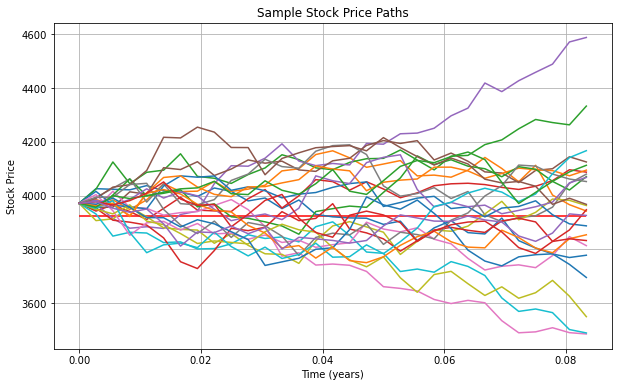

The estimated price of the European put for SPX put expiring in 1 month is $65.60


In [10]:
# Example usage with a random SPX options contract currently
S0 = 3970.99          # Initial stock price
K = 3925.00           # Strike price
T = (1/12)            # Time to maturity (in years)
r = 0.0338            # Risk-free interest rate
sigma = 0.2012        # Volatility of the underlying asset
option_type = 'put'

option_price = monte_carlo_european_option_pricing(S0, K, T, r, sigma, option_type, plot=True)
print(f"The estimated price of the European {option_type} for SPX put expiring in 1 month is ${option_price:.2f}")


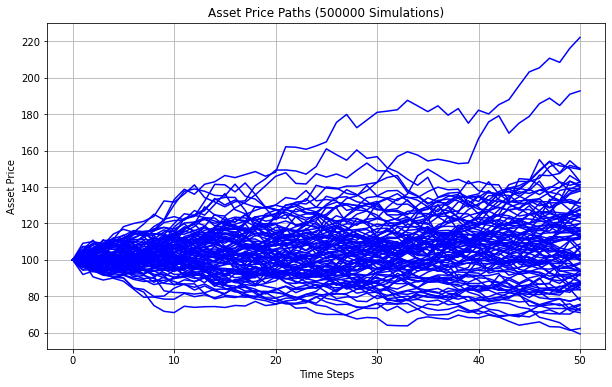

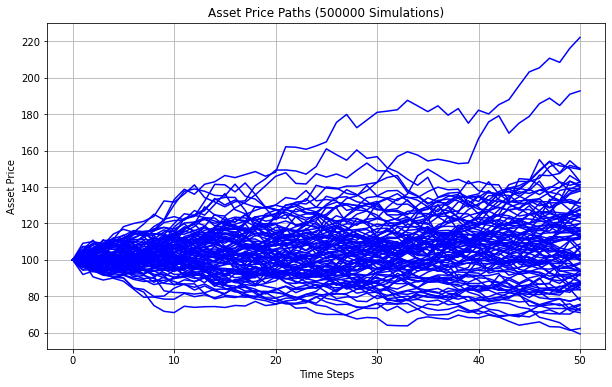

American call option price: 6.138676007903306
American put option price: 11.811555154183559


In [16]:
import numpy as np
import numpy.random as npr
from sklearn.linear_model import LinearRegression

def generate_paths(init_price, int_rate, vol, ttm, time_steps, num_sims):
    """
    Generate Monte Carlo paths for the underlying asset price.

    Parameters:
    :param init_price: Initial asset price
    :param int_rate: Risk-free interest rate
    :param vol: Volatility of the underlying asset
    :param ttm: Time to maturity
    :param time_steps: Number of time steps
    :param num_sims: Number of simulated paths

    Returns:
    ndarray: Asset price paths
    """
    dt = ttm / time_steps
    S = np.zeros((time_steps + 1, num_sims))
    S[0] = init_price
    rand = npr.standard_normal(S.shape)
    for t in range(1, time_steps + 1):
        S[t] = S[t - 1] * np.exp((int_rate - 0.5 * vol ** 2) * dt + vol * np.sqrt(dt) * rand[t])
    return S

def lsm_american_option_pricing(paths, strike_price, int_rate, ttm, option_category='call', plot=False):
    """
    Price an American option using the Longstaff-Schwartz Method.

    Parameters:
    :param paths: Asset price paths
    :param strike_price: Strike price
    :param int_rate: Risk-free interest rate
    :param ttm: Time to maturity
    :param option_category: 'call' or 'put'
    :param plot: boolean flag to toggle plotting

    Returns:
    float: American option price
    """
    if option_category not in ['call', 'put']:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

    M, I = paths.shape
    M = M - 1
    dt = ttm / M
    df = np.exp(-int_rate * dt)

    if option_category == 'call':
        h = np.maximum(paths - strike_price, 0)
    else:
        h = np.maximum(strike_price - paths, 0)

    V = h[-1]

    for t in range(M - 1, 0, -1):
        # Select in-the-money paths
        itm = h[t] > 0

        # If there are no in-the-money paths, continue to the next time step
        if not np.any(itm):
            continue

        # Fit regression model
        X = paths[t, itm].reshape(-1, 1)
        Y = V[itm] * df
        model = LinearRegression()
        model.fit(X, Y)

        # Calculate continuation values
        cont_val = model.predict(X)

        # Update option values
        V[itm] = np.where(h[t, itm] > cont_val, h[t, itm], V[itm] * df)

    # Calculate and return option price
    V0 = np.mean(V * df)

    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(paths[:, :100], 'b', lw=1.5)
        plt.xlabel('Time Steps')
        plt.ylabel('Asset Price')
        plt.title(f'Asset Price Paths ({I} Simulations)')
        plt.grid(True)
        plt.show()

    return V0

# Example usage
S0 = 100
K = 110
r = 0.05
sigma = 0.2
T = 1
M = 50
I = 500000

S = generate_paths(S0, r, sigma, T, M, I)
call_price = lsm_american_option_pricing(S, K, r, T, option_category='call', plot = True)
put_price = lsm_american_option_pricing(S, K, r, T, option_category='put', plot = True)

print("American call option price:", call_price)
print("American put option price:", put_price)

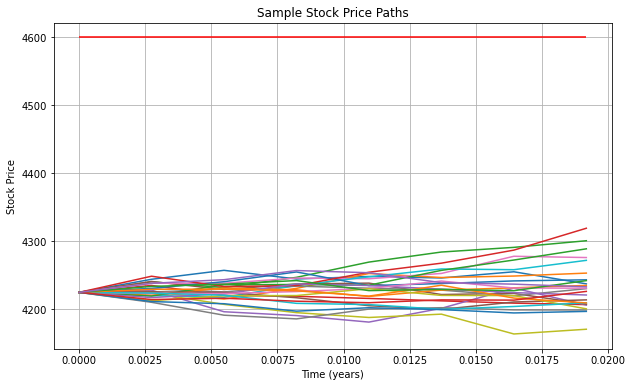

375.1390527388942

In [17]:
#Example testing using eu_df for NDX index fund
row = eu_df.iloc[658767]
monte_carlo_european_option_pricing(
    row["Close/Last"],
    row["strike_price"] / 1000,
    row["tte"].days / 365,
    row["FEDFUNDS"] / 100,
    row["volatility"],
    type_of_option= "Call" if row["cp_flag"] == "C" else "Put",
    plot=True
)

The model has an accuracy of 0.47909473626643406 over the whole chain.
The model has an accuracy of 0.3005263683343497 over the middle 50% of the options chain.


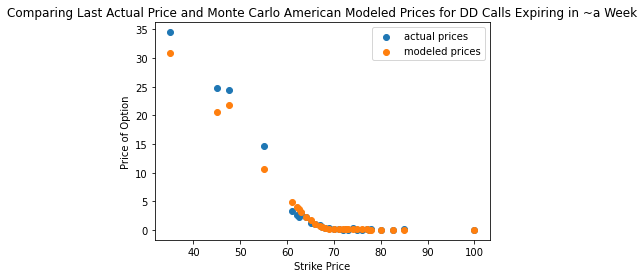

The model has an accuracy of 0.178895430722104 over the whole chain.
The model has an accuracy of 0.08038080834764295 over the middle 50% of the options chain.


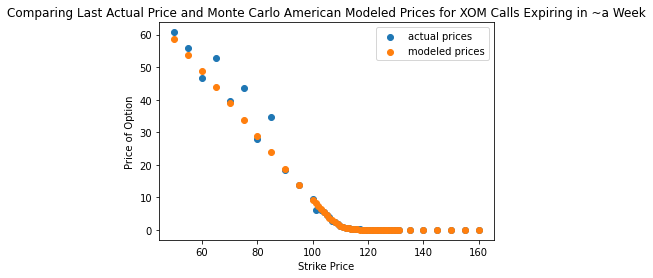

The model has an accuracy of 0.5317628227635195 over the whole chain.
The model has an accuracy of 0.6664513259708028 over the middle 50% of the options chain.


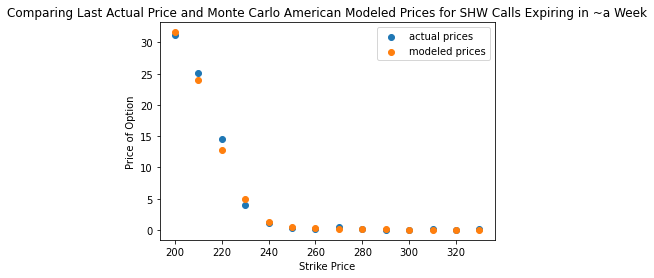

The model has an accuracy of 0.17126662629165662 over the whole chain.
The model has an accuracy of 0.08644911929418483 over the middle 50% of the options chain.


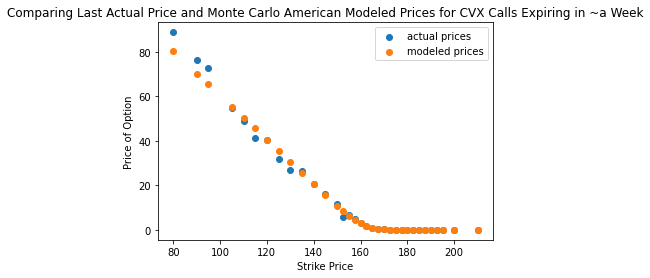

The model has an accuracy of 0.18668149555887179 over the whole chain.
The model has an accuracy of 0.04732020227051253 over the middle 50% of the options chain.


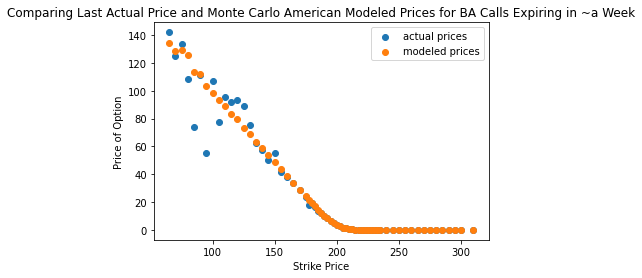

The model has an accuracy of 0.3333658964921453 over the whole chain.
The model has an accuracy of 0.3251723766156753 over the middle 50% of the options chain.


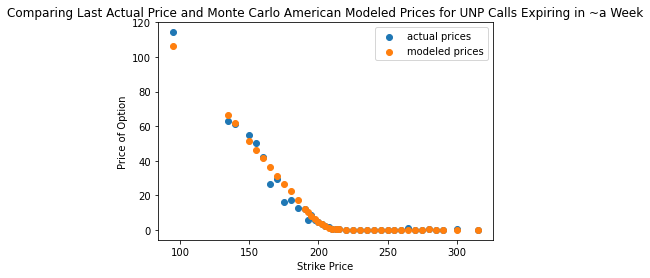

The model has an accuracy of 0.12715212872809292 over the whole chain.
The model has an accuracy of 0.08235332208322887 over the middle 50% of the options chain.


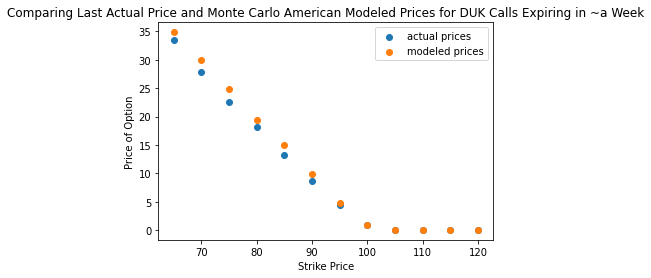

The model has an accuracy of 0.2747898920457072 over the whole chain.
The model has an accuracy of 0.1828328937786778 over the middle 50% of the options chain.


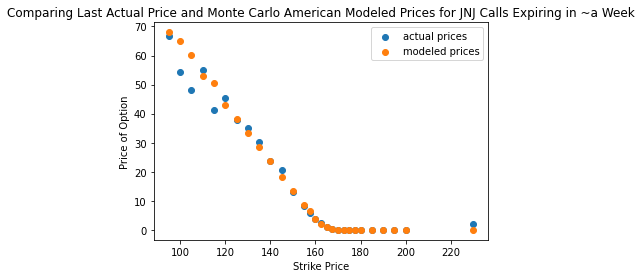

The model has an accuracy of 0.4135533069234963 over the whole chain.
The model has an accuracy of 0.08009953723679743 over the middle 50% of the options chain.


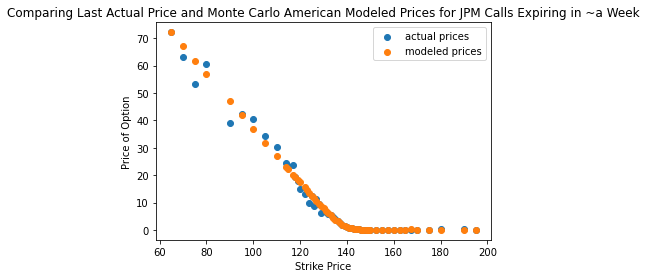

The model has an accuracy of 0.2314879886790122 over the whole chain.
The model has an accuracy of 0.09199609399139501 over the middle 50% of the options chain.


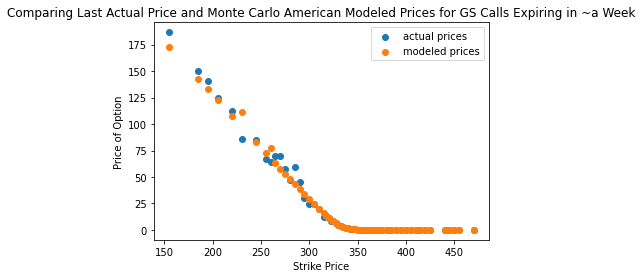

The model has an accuracy of 0.1204974755942272 over the whole chain.
The model has an accuracy of 0.027969751519801772 over the middle 50% of the options chain.


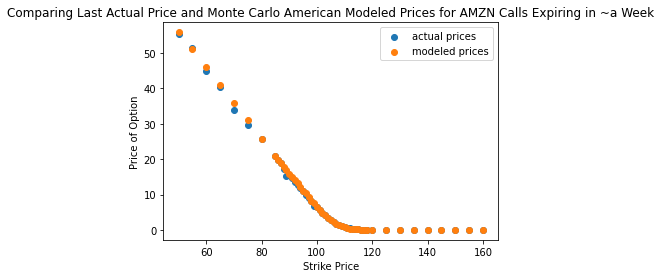

The model has an accuracy of 0.605884375249032 over the whole chain.
The model has an accuracy of 0.04914554227429692 over the middle 50% of the options chain.


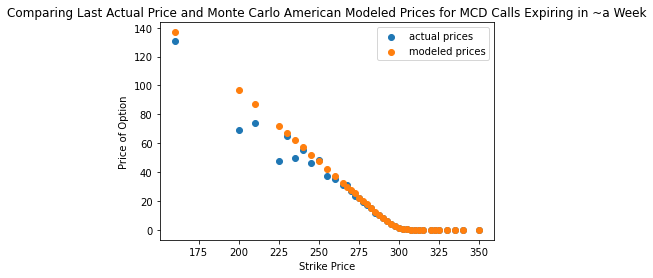

The model has an accuracy of 0.3591638352461611 over the whole chain.
The model has an accuracy of 0.03412733307059963 over the middle 50% of the options chain.


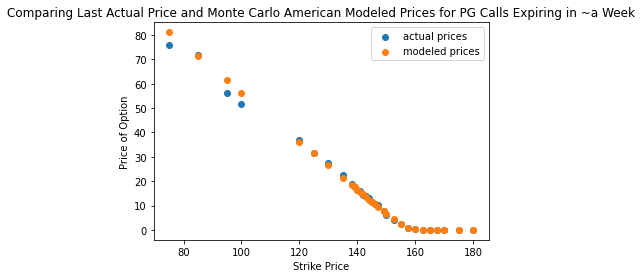

The model has an accuracy of 0.21478391335589517 over the whole chain.
The model has an accuracy of 0.11478488789528266 over the middle 50% of the options chain.


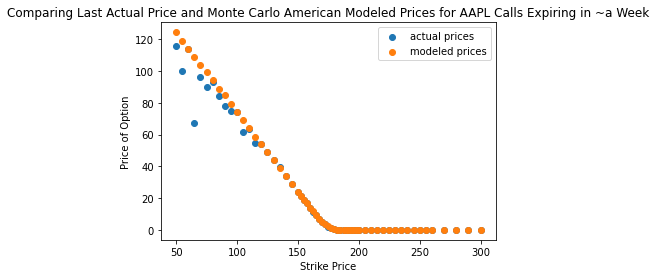

The model has an accuracy of 0.3874334614092656 over the whole chain.
The model has an accuracy of 0.050540592111734645 over the middle 50% of the options chain.


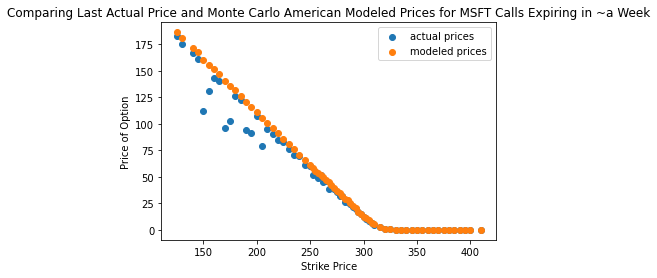

The model has an accuracy of 1.5663671430943753 over the whole chain.
The model has an accuracy of 0.1294057099874961 over the middle 50% of the options chain.


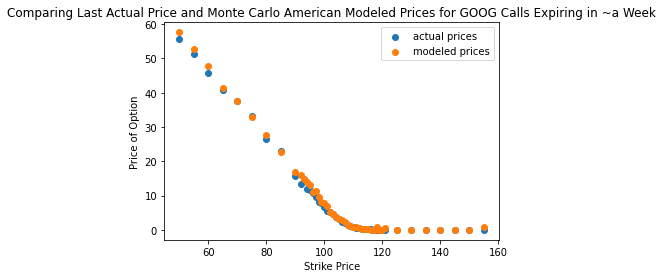

The model has an accuracy of 0.5271352217560783 over the whole chain.
The model has an accuracy of 0.13052770431736 over the middle 50% of the options chain.


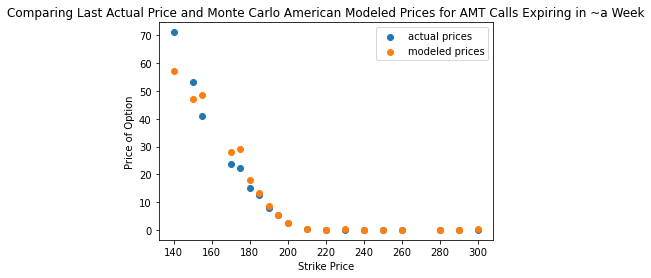

In [23]:
int_rate = 0.0344 #risk free interest rate today
def compare(ticker,date):
    """
    Generates plots comparing the modeled prices from the Binomial Model Tree to
    actual stock data.
    ticker: ticker for the stock
    date: options expiration date
    """
    formatted_date = datetime.date(int(date[0:4]),int(date[5:7]),int(date[8::]))
    tte = formatted_date - datetime.date.today()
    stock = yf.Ticker(ticker)
    stock_price = stock.info['currentPrice']
    opt_chain = stock.option_chain(date)
    calls = opt_chain.calls
    calls["modeled_price"] = 0
    calls["percent_error"] = 0
    for i in range(0,calls.shape[0]):
        S0 = stock_price
        K = calls['strike'][i]
        sigma = calls['impliedVolatility'][i]
        T = tte.days / 365
        M = 50
        I = 50000

        S = generate_paths(S0, int_rate, sigma, T, M, I)
        calculated_price = lsm_american_option_pricing(S, K, int_rate, T, option_category='call')
        calls["modeled_price"][i] = calculated_price if (calculated_price < 2000 and calculated_price > 0) else 0
        calls["percent_error"][i] = abs((calls['lastPrice'][i] - calls["modeled_price"][i])/calls['lastPrice'][i])
    print("The model has an accuracy of " + str(calls["percent_error"].mean()) + " over the whole chain.")
    bottom = calls.shape[0]//4
    top = bottom*3
    print("The model has an accuracy of " + str(calls["percent_error"][bottom:top].mean()) + " over the middle 50% of the options chain.")
    plt.scatter(calls['strike'].to_numpy(),calls['lastPrice'].to_numpy(),label="actual prices")
    plt.scatter(calls['strike'].to_numpy(),calls["modeled_price"].to_numpy(),label="modeled prices")
    plt.title('Comparing Last Actual Price and Monte Carlo American Modeled Prices for ' + ticker + ' Calls Expiring in ~a Week')
    plt.ylabel('Price of Option')
    plt.xlabel('Strike Price')
    plt.legend()
    plt.show()
    return

stocks = {
    "DD":'2023-05-19', #Energy Sector
    "XOM":'2023-05-19', #Energy Sector
    "SHW":'2023-05-19', #Materials Sector
    "CVX":'2023-05-19', #Materials Sector
    "BA":'2023-05-19', #Industrial Sector
    "UNP":'2023-05-19', #Industrial Sector
    "DUK": '2023-05-19', #Healthcare
    "JNJ": '2023-05-19', #Healthcare
    "JPM": '2023-05-19', #Financial
    "GS" :'2023-05-19', #Financial
    "AMZN" :'2023-05-19', #Consumer Discretionary Sector
    "MCD" :'2023-05-19', #Consumer Discretionary Sector
    "PG" :'2023-05-19',#Consume Staples Sector
    "AAPL":'2023-05-19', #Tech Sector
    "MSFT": '2023-05-19',#Tech Sector
    "GOOG":'2023-05-19', #Communication Sector
    "AMT": '2023-05-19', #Real Estate
    }

for key in stocks:
    compare(key,'2023-05-19')